In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
from fastai.vision import *
sys.path.append("dev/")
path = Path('../data/histopathologic/');path.ls()

[PosixPath('../data/histopathologic/train'),
 PosixPath('../data/histopathologic/patch_id_wsi.csv'),
 PosixPath('../data/histopathologic/sample_submission.csv'),
 PosixPath('../data/histopathologic/preds'),
 PosixPath('../data/histopathologic/submissions'),
 PosixPath('../data/histopathologic/train_labels.csv'),
 PosixPath('../data/histopathologic/logs'),
 PosixPath('../data/histopathologic/models'),
 PosixPath('../data/histopathologic/ensemble'),
 PosixPath('../data/histopathologic/test')]

In [2]:
wsi_ids = pd.read_csv(path/'patch_id_wsi.csv')

In [3]:
wsi_ids.head()

,id,wsi
0,f38a6374c348f90b587e046aac6079959adf3835,camelyon16_train_normal_033
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,camelyon16_train_tumor_054
2,755db6279dae599ebb4d39a9123cce439965282d,camelyon16_train_tumor_008
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,camelyon16_train_tumor_077
4,acfe80838488fae3c89bd21ade75be5c34e66be7,camelyon16_train_tumor_036


In [4]:
wsi_ids.wsi.shape

(192752,)

In [5]:
df = pd.read_csv(path/'train_labels.csv')
df = pd.merge(df,wsi_ids,on='id',how='left')

In [14]:
print(f"missing WSI: {np.round(df.wsi.isna().sum()/len(df), 3)}"); df.head()

missing WSI: 0.124


,id,label,wsi
0,f38a6374c348f90b587e046aac6079959adf3835,0,camelyon16_train_normal_033
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,camelyon16_train_tumor_054
2,755db6279dae599ebb4d39a9123cce439965282d,0,camelyon16_train_tumor_008
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,camelyon16_train_tumor_077
4,068aba587a4950175d04c680d38943fd488d6a9d,0,NaN


In [7]:
# df.wsi.isna().sum() / len(df)
# df.wsi.nunique()
# unique_ids = np.unique(df.wsi.dropna()); len(unique_ids)
# np.random.seed(42)
# nfolds = 5
# fold_ids = np.array_split(np.random.permutation(unique_ids), nfolds); len(fold_ids)
# cv_idxs = []
# for i in range(len(fold_ids)):
#     cv_idxs.append((np.where(df['wsi'].isin(fold_ids[i]))[0],
#     np.where(~df['wsi'].isin(fold_ids[i]))[0]))
# for i in range(len(fold_ids)):
#     print(len(cv_idxs[i][0]), len(cv_idxs[i][1]))

**Create validation folds which doesn't (almost) have overlapping WSI Ids.**

In [15]:
tfms = get_transforms(True, True, max_rotate=15, max_zoom=1.2, max_lighting=0.3,
                      max_warp=0, p_affine=0.5, p_lighting=0.5, xtra_tfms=[])

def get_data(trn_idx, val_idx, tfms=tfms):
    data = (ImageList.from_df(df=df, path=path, folder='train', suffix='.tif')
        .split_by_idx(valid_idx=val_idx)
        .label_from_lists(train_labels=list(df['label'].iloc[trn_idx].values),
                                        valid_labels=list(df['label'].iloc[val_idx].values))
        .transform(tfms)
        .databunch()
        .normalize(imagenet_stats))
    data.add_test(ImageList.from_folder(path/'test'))
    return data

In [9]:
# pd.to_pickle(cv_idxs, path/'models/cv_non_overlap_idxs.pkl')
# cv_data = [get_data(idxs[1], idxs[0]) for idxs in cv_idxs]
# pd.to_pickle(cv_data, path/'models/cv_non_overlap_data.pkl')

### training

In [16]:
from metric_utils import AUC
from fastai.callbacks import *

In [17]:
cv_data = pd.read_pickle(path/'models/cv_non_overlap_data.pkl')
arch = models.densenet201
model_name = arch.__name__ 
model_suffix = "_non_overlap"
print(f"Starting Training with model: {model_name}")

Starting Training with model: densenet201


In [18]:
MODEL_NAME = f"{model_name}{model_suffix}"; MODEL_NAME

'densenet201_non_overlap'

In [19]:
cv_data

[ImageDataBunch;
 
 Train: LabelList (181087 items)
 x: ImageList
 Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
 y: CategoryList
 0,0,0,0,0
 Path: ../data/histopathologic;
 
 Valid: LabelList (38938 items)
 x: ImageList
 Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
 y: CategoryList
 1,0,0,1,0
 Path: ../data/histopathologic;
 
 Test: LabelList (57458 items)
 x: ImageList
 Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
 y: EmptyLabelList
 ,,,,
 Path: ../data/histopathologic, ImageDataBunch;
 
 Train: LabelList (184768 items)
 x: ImageList
 Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
 y: CategoryList
 0,1,0,0,0
 Path: ../data/histopathologic;
 
 Valid: LabelList (35257 items)
 x: ImageList
 Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
 y: CategoryList
 1,0,0,0,0
 Path:

In [23]:
# define callbacks
i = 0 
fold_num = i
fold_data = cv_data[i]

# create saved model dir
os.makedirs(path/f'models/best_of_{MODEL_NAME}', exist_ok=True)

# Initialize Learner
print(f"Initialize Learner at fold{fold_num}")
auc = AUC()
learn_callbacks = [TerminateOnNaNCallback()]
learn_callback_fns = [partial(EarlyStoppingCallback, monitor='auc', mode='max', patience=3),
                      
                      partial(SaveModelCallback, monitor='auc', mode='max', every='improvement',
                              name=f'best_of_{MODEL_NAME}/fold{fold_num}'),
                      
                      partial(ReduceLROnPlateauCallback, monitor='auc', mode='max', patience=0, factor=0.9),
                      
                      partial(CSVLogger, filename=f'logs/{MODEL_NAME}', append=True)]

Initialize Learner at fold0


In [24]:
learn_callbacks

[TerminateOnNaNCallback]

In [25]:
learn_callback_fns

[functools.partial(<class 'fastai.callbacks.tracker.EarlyStoppingCallback'>, monitor='auc', mode='max', patience=3),
 functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, monitor='auc', mode='max', every='improvement', name='best_of_densenet201_non_overlap/fold0'),
 functools.partial(<class 'fastai.callbacks.tracker.ReduceLROnPlateauCallback'>, monitor='auc', mode='max', patience=0, factor=0.9),
 functools.partial(<class 'fastai.callbacks.csv_logger.CSVLogger'>, filename='logs/densenet201_non_overlap', append=True)]

In [27]:
torch.cuda.is_available()

False

In [26]:
learn = cnn_learner(data=fold_data, base_arch=arch, metrics=[accuracy, auc], 
                    lin_ftrs=[1024,1024], ps=[0.7, 0.7, 0.7],
                    callbacks=learn_callbacks,
                    callback_fns=learn_callback_fns)

RuntimeError: cuda runtime error (30) : unknown error at /pytorch/aten/src/THC/THCGeneral.cpp:51

In [52]:
learn.fit(1)

Stage-1


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-03


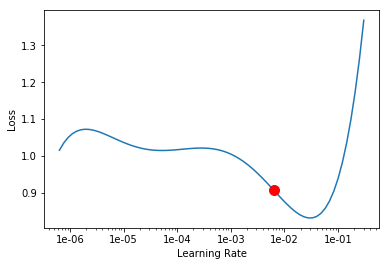

In [44]:
# Stage-1 training
print("Stage-1")
learn.lr_find()
try:
    learn.recorder.plot(suggestion=True, k=5)
except: 
     learn.recorder.plot(suggestion=True)
max_lr = learn.recorder.min_grad_lr

In [45]:
print(f"Stage-1 training with lr={max_lr}")
learn.fit_one_cycle(50, max_lr=max_lr)

Stage-1 training with lr=0.006309573444801929


KeyboardInterrupt: 

In [ ]:
# Stage-2 training
print("Stage-2")
learn.freeze_to(1)
learn.lr_find()
try:
    learn.recorder.plot(suggestion=True, k=5)
except: 
     learn.recorder.plot(suggestion=True)
max_lr = learn.recorder.min_grad_lr
print(f"Stage-2 training with lr={max_lr}")
learn.fit_one_cycle(20, max_lr=[max_lr/10, max_lr/3, max_lr])

In [ ]:
# Stage-3 training
print("Stage-3")
learn.unfreeze()
learn.lr_find()
try:
    learn.recorder.plot(suggestion=True, k=5)
except: 
     learn.recorder.plot(suggestion=True)
max_lr = learn.recorder.min_grad_lr
print(f"Stage-3 training with lr={max_lr}")
learn.fit_one_cycle(5, max_lr=[max_lr/10, max_lr/3, max_lr])

In [ ]:
print(f"Training of fold{fold_num} model is done...destroying learner")
learn.destroy()